In [1]:
import numpy as np
import pandas as pd
from cv2 import imread
import ml_utils as ml
import matplotlib.pyplot as plt

import h5py
from numpy.core.defchararray import add

import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input,Dense,Flatten, 
                                     Conv2D ,MaxPool2D,
                                     GlobalAvgPool2D,
                                     Activation, Dropout,
                                     concatenate, ReLU,LeakyReLU,
                                    Lambda,BatchNormalization,
                                    SeparableConv2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import (ModelCheckpoint,
                                        EarlyStopping)
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,accuracy_score

In [2]:
!which ipython

~/.conda/envs/tensorflowenvpy39/bin/ipython


# Loading Data

In [3]:
data_dir_old = '/home/srashti.goyal/alice_data_lensid/qts/train/'
data_dir_ml2p0 = '/home/srashti.goyal/lensid_runs/ML_2p0_AnalyticalPsd/data/qts/train/'

In [4]:
data_dir_ml1p0 = '/home/srashti.goyal/lensid_runs/ML_1p0_AnalyticalPsd/data/qts/train/'


In [5]:
mode = 'ml1p0' # old, 'ml1p0', 'ml2p0','ml1p0_qmode2','ml1p0_whiten'



# Training

In [6]:
lensed_df = '/home/srashti.goyal/lensid_runs/ML_2p0_AnalyticalPsd/data/dataframes/train/lensed.csv'

In [7]:
lensed_df_old = '../lensed_old.csv'

In [8]:
unlensed_df = '/home/srashti.goyal/lensid_runs/ML_2p0_AnalyticalPsd/data/dataframes/train/unlensed_half.csv'

In [9]:
df_lensed = pd.read_csv(lensed_df)#pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Lensed_full_qtransforms/Lensed_dataset_full.csv" )
df_lensed=df_lensed.drop(columns=['Unnamed: 0'])
df_lensed.tail()

,img_0,img_1,Lensing
2808,2808_0,2808_1,1
2809,2809_0,2809_1,1
2810,2810_0,2810_1,1
2811,2811_0,2811_1,1
2812,2812_0,2812_1,1


In [10]:
df_unlensed = pd.read_csv(unlensed_df)#pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Unlensed_full_qtransforms/Unlensed_dataset_full.csv" )
df_unlensed=df_unlensed.drop(columns=['Unnamed: 0'])
df_unlensed.tail()

,img_0,img_1,Lensing
124745,496,498,0
124746,496,499,0
124747,497,498,0
124748,497,499,0
124749,498,499,0


In [11]:
# size of the training dataset
size=1410 # for each lensed and unlensed

# to choose test dataset different from the train one remember this random state.
df_unlensed=df_unlensed.sample(frac = 1,random_state = 42).reset_index(drop = True)[:size]
df_lensed=df_lensed[:size]

# training data set
df_train = pd.concat([df_lensed,df_unlensed],ignore_index = True)
df_train=df_train.sample(frac = 1,random_state = 42).reset_index(drop = True)[:2*size]
df_train

,img_0,img_1,Lensing
0,1090_0,1090_1,1
1,84,91,0
2,772_0,772_1,1
3,1110_0,1110_1,1
4,1,96,0
...,...,...,...
2815,275,366,0
2816,1095_0,1095_1,1
2817,1130_0,1130_1,1
2818,1294_0,1294_1,1


In [12]:
det='H1'
x_train_0,x_train_1, labels,missing_ids=ml.generate_resize_siamese_fm(df_train).Siamese_input_matrix(
        det,
        data_mode_dense="current",
        data_dir=data_dir_ml1p0)

In [13]:
# the set of images 0 and 1 being given to the siamese network
#x_train_0 = read_spectograms(img_0_paths,img_rows,img_cols,as_gray,in_channel)
#x_train_1 = read_spectograms(img_1_paths,img_rows,img_cols,as_gray,in_channel)
#labels = df_train.Lensing.values
IMG_SHAPE = x_train_0[0].shape#(128,128,1)
np.max(x_train_0), np.min(x_train_0),np.max(x_train_1), np.min(x_train_1),x_train_1.shape

(1.0, 0.0039525693, 1.0, 0.0039525693, (2820, 128, 128, 3))

In [14]:
#x_train_0, x_train_1 = x_train_0[:,:,:,1], x_train_1[:,:,:,1]
#x_train_0, x_train_1 = [np.expand_dims(arr,axis=-1) for arr in [x_train_0,x_train_1]]
#x_train_0.shape, x_train_1.shape

In [15]:
# double the dataset by flipping the images in x_train_0 and x_train_1
x_train_a = np.vstack([x_train_0,x_train_1])
x_train_b = np.vstack([x_train_1,x_train_0])
y_train = np.hstack([labels,labels])
x_train_a.shape, x_train_b.shape, y_train.shape

((5640, 128, 128, 3), (5640, 128, 128, 3), (5640,))

In [16]:
def tr_te_split(x_train_a,x_train_b,y_train,split=0.2):
    rng = np.random.default_rng()
    n_train = len(y_train)
    idx = np.arange(n_train)
    rng.shuffle(idx)
    x_train_a = x_train_a[idx]
    x_train_b = x_train_b[idx]
    y_train = y_train[idx]
    split_idx = int(n_train*split)
    #split = lambda arr, idx : arr[idx:], arr[:idx]
    x_tr_a, x_te_a = x_train_a[split_idx:], x_train_a[:split_idx]
    x_tr_b, x_te_b = x_train_b[split_idx:], x_train_b[:split_idx]
    y_tr, y_te = y_train[split_idx:], y_train[:split_idx]
    return (x_tr_a,x_tr_b), (x_te_a,x_te_b), (y_tr,y_te)

(x_tr_a,x_tr_b), (x_val_a,x_val_b), (y_tr,y_val) = tr_te_split(x_train_a,
                                                              x_train_b,
                                                              y_train,
                                                              split=0.2)

print(len(x_tr_a)+len(x_val_b)-len(x_train_a))

del x_train_a, x_train_b, y_train, x_train_0, x_train_1

0


# Siamese Network

In [17]:
def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=True)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=True)(x)
    x = BatchNormalization()(x)
    return x

def siamese_feature_extractor(inputShape, embeddingDim=3):
    inputs = Input(inputShape)
    x = conv_bn(x=inputs, filters=16, kernel_size=1, strides=1)
    x = ReLU()(x) # 256,256,16

    x = sep_bn(x=x, filters=32, kernel_size=5, strides=2)
    x = ReLU()(x) # 128,128,32
    x = sep_bn(x=x, filters=64, kernel_size=5, strides=2)

    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x) 

    x = ReLU()(x) # 64,64,64
    x = sep_bn(x=x, filters=128, kernel_size=3, strides=2)
    x = ReLU()(x) # 32,32,128
    x = sep_bn(x=x, filters=256, kernel_size=3, strides=2) # 16,16,256

    x = ReLU()(x) # 8,8,256

    x = GlobalAvgPool2D()(x) # 1,1,256

    x = Dropout(rate=0.1)(x)

    x = Dense(units=64, activation='elu')(x)
    x = Dense(units=16, activation='elu')(x)
    output = Dense(units=embeddingDim, activation='elu')(x)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=0.3):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [18]:
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = siamese_feature_extractor(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] building siamese network...


In [ ]:
BATCH_SIZE = 32
EPOCHS = 50
margin = 0.2

# compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer="adam")
# train the model
print("[INFO] training model...")
history = model.fit([x_tr_a, x_tr_b],y_tr,
                    validation_data=([x_val_a, x_val_b], y_val),
                    batch_size=BATCH_SIZE,epochs=EPOCHS)

[INFO] compiling model...
[INFO] training model...
Epoch 1/50
141/141 [==============================] - 20s 145ms/step - loss: 0.0251 - val_loss: 0.0441
Epoch 2/50
141/141 [==============================] - 19s 137ms/step - loss: 0.0130 - val_loss: 0.0183
Epoch 3/50
141/141 [==============================] - 20s 139ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 4/50
141/141 [==============================] - 20s 140ms/step - loss: 0.0089 - val_loss: 0.0163
Epoch 5/50
141/141 [==============================] - 19s 134ms/step - loss: 0.0079 - val_loss: 0.0087
Epoch 6/50
141/141 [==============================] - 19s 137ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 7/50
141/141 [==============================] - 20s 139ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 8/50
141/141 [==============================] - 20s 140ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/50
141/141 [==============================] - 20s 144ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 10/50
141/141 [=

# Visualizing the Learned Similarity Score

In [ ]:
d_tr_pred = model.predict([x_tr_a, x_tr_b])

In [ ]:
idx_true = np.where(y_tr==1)
idx_false = np.where(y_tr==0)
np.mean(d_tr_pred[idx_true]), np.std(d_tr_pred[idx_true])

In [ ]:
plt.hist(d_tr_pred[idx_true],color='b',alpha=0.4,label = 'positive pairs')
plt.hist(d_tr_pred[idx_false],color='r',alpha=0.4, label= 'negative pairs')
plt.xlabel('distance between pairs')
plt.ylabel('population')
plt.legend(loc='best')
plt.show()

In [ ]:
d_val_pred = model.predict([x_val_a, x_val_b])
idx_val_true = np.where(y_val==1)
idx_val_false = np.where(y_val==0)

plt.hist(d_val_pred[idx_val_true],color='b',alpha=0.4,label = 'positive pairs')
plt.hist(d_val_pred[idx_val_false],color='r',alpha=0.4, label= 'negative pairs')
plt.xlabel('distance between pairs')
plt.ylabel('population')
plt.legend(loc='best')
plt.show()

# Making Predictions

Start with an ad hoc procedure. The pair is lensed if the distance between the two images in embedding space is less than or equal to the mean+std dev of distance of positive images in the train set.

Later we will refine this.

In [ ]:
threshold = np.mean(d_tr_pred[idx_true])+ np.std(d_tr_pred[idx_true])
threshold

In [ ]:
idx_true = np.where(y_val==1)
idx_false = np.where(y_val==0)
np.mean(d_val_pred[idx_true]), np.std(d_val_pred[idx_true]),np.mean(d_val_pred[idx_false]), np.std(d_val_pred[idx_false])

In [ ]:
lensed = np.where(np.squeeze(d_val_pred)<=threshold)
unlensed = np.where(np.squeeze(d_val_pred)>threshold)

In [ ]:
y_pred = 2.*np.ones_like(y_val)
y_pred[lensed] = 1
y_pred[unlensed] = 0

In [ ]:
confusion_matrix(y_val,y_pred), accuracy_score(y_val,y_pred)

# Computing Precision and Recall

\begin{equation}
precision = \frac{TP}{TP+FP}\,, \qquad recall = \frac{TP}{TP+FN}
\end{equation}

if our classifier is perfect then false positives (fp) and false negatives (fn) are both zero. precision and recall are both 1. 

We would therefore like to tune our classifier so that precision and recall are simultaneously as close to 1 as possible.

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [30]:
thresholds = np.arange(0,0.4,1e-2)
precision, recall = [], []

for threshold in thresholds:
    idx_true = np.where(y_tr==1)
    idx_false = np.where(y_tr==0)
    lensed = np.where(np.squeeze(d_tr_pred)<=threshold)
    unlensed = np.where(np.squeeze(d_tr_pred)>threshold)
    y_pred = 2.*np.ones_like(y_tr)
    y_pred[lensed] = 1
    y_pred[unlensed] = 0
    prec, rec = precision_score(y_tr,y_pred), recall_score(y_tr,y_pred)
    precision.append(prec)
    recall.append(rec)
    

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py37-20210512/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


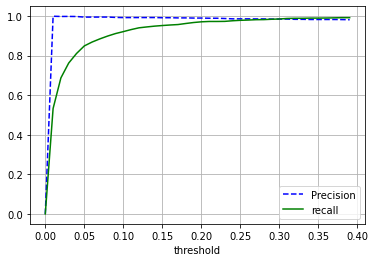

In [31]:
plt.plot(thresholds, precision, 'b--', label='Precision')
plt.plot(thresholds, recall, 'g-',label='recall')
plt.legend(loc='best')
plt.xlabel('threshold')
plt.grid('both')
plt.show()

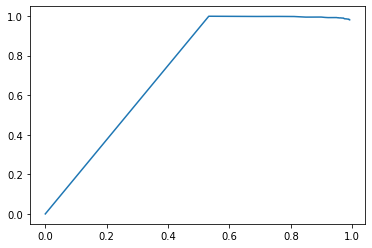

In [32]:
plt.plot(recall,precision)
plt.show()

The first curve suggests that the threshold should be about 0.12

In [33]:
t_idx = np.argmin(np.abs(np.asarray(precision)-np.asarray(recall))[1:])
thresholds[t_idx]

0.29

In [34]:
threshold = thresholds[t_idx]

idx_true = np.where(y_val==1)
idx_false = np.where(y_val==0)

lensed = np.where(np.squeeze(d_val_pred)<=threshold)
unlensed = np.where(np.squeeze(d_val_pred)>threshold)

y_pred = 2.*np.ones_like(y_val)
y_pred[lensed] = 1
y_pred[unlensed] = 0

confusion_matrix(y_val,y_pred), accuracy_score(y_val,y_pred)

(array([[523,  26],
        [ 28, 551]]),
 0.9521276595744681)

# Plot ROC curve

In [35]:
thresholds = np.arange(0,0.4,1e-2)
tprs, fprs = [], []

for threshold in thresholds:
    idx_true = np.where(y_tr==1)
    idx_false = np.where(y_tr==0)
    lensed = np.where(np.squeeze(d_tr_pred)<=threshold)
    unlensed= np.where(np.squeeze(d_tr_pred)>threshold)
    y_pred = 2.*np.ones_like(y_tr)
    y_pred[lensed] = 1
    y_pred[unlensed] = 0
    tpr = recall_score(y_tr,y_pred)
    C = confusion_matrix(y_tr,y_pred)
    fpr = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)

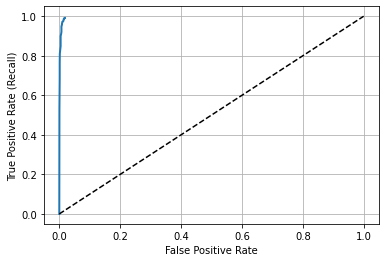

In [36]:
plt.plot(fprs,tprs,linewidth=2,label='ROC curve')
plt.plot([0,1],[0,1],'k--')
plt.grid('both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

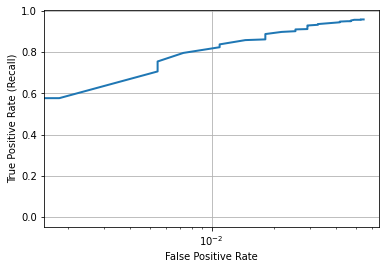

In [37]:
thresholds = np.arange(0,0.4,1e-2)
tprs, fprs = [], []

for threshold in thresholds:
    idx_true = np.where(y_val==1)
    idx_false = np.where(y_val==0)
    lensed = np.where(np.squeeze(d_val_pred)<=threshold)
    unlensed= np.where(np.squeeze(d_val_pred)>threshold)
    y_pred = 2.*np.ones_like(y_val)
    y_pred[lensed] = 1
    y_pred[unlensed] = 0
    tpr = recall_score(y_val,y_pred)
    C = confusion_matrix(y_val,y_pred)
    fpr = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)
plt.plot(fprs,tprs,linewidth=2,label='ROC curve')
#plt.plot([0,1],[0,1],'k--')
plt.xscale('log')

plt.grid('both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [40]:
# test 

df_unlensed = pd.read_csv(unlensed_df)#pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Unlensed_full_qtransforms/Unlensed_dataset_full.csv" )
df_unlensed=df_unlensed.drop(columns=['Unnamed: 0'])
df_unlensed.tail()

,img_0,img_1,Lensing
124745,496,498,0
124746,496,499,0
124747,497,498,0
124748,497,499,0
124749,498,499,0


In [41]:
size_test = 400

# to choose test dataset different from the train one remember this random state.
df_unlensed=df_unlensed.sample(frac = 1,random_state = 42).reset_index(drop = True)[-size_test:]
df_lensed=df_lensed[-size_test:]

# testing data set
df_test = pd.concat([df_lensed,df_unlensed],ignore_index = True)
df_test=df_test.sample(frac = 1,random_state = 42).reset_index(drop = True)[:2*size_test]
df_test

,img_0,img_1,Lensing
0,2,22,0
1,108,185,0
2,1073_0,1073_1,1
3,233,469,0
4,1076_0,1076_1,1
...,...,...,...
795,1081_0,1081_1,1
796,1116_0,1116_1,1
797,1280_0,1280_1,1
798,176,447,0


In [52]:
x_test_0,x_test_1, labels,missing_ids=ml.generate_resize_siamese_fm(df_test).Siamese_input_matrix(
        det,
        data_mode_dense="current",
        data_dir=data_dir_ml1p0)

In [53]:

# the set of images 0 and 1 being given to the siamese network
#x_test_0 = read_spectograms(img_0_paths,img_rows,img_cols,as_gray,in_channel)
#x_test_1 = read_spectograms(img_1_paths,img_rows,img_cols,as_gray,in_channel)
#labels = df_test.Lensing.values
IMG_SHAPE = x_test_0[0].shape#(128,128,1)
#np.max(x_train_0), np.min(x_train_0),np.max(x_train_1), np.min(x_train_1),x_train_1.shape

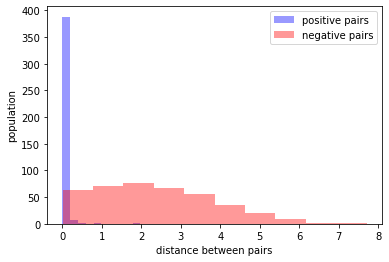

In [65]:
d_test_pred = model.predict([x_test_0, x_test_1])
idx_test_true = np.where(labels==1)
idx_test_false = np.where(labels==0)

plt.hist(d_test_pred[idx_test_true],color='b',alpha=0.4,label = 'positive pairs')
plt.hist(d_test_pred[idx_test_false],color='r',alpha=0.4, label= 'negative pairs')
plt.xlabel('distance between pairs')
plt.ylabel('population')
plt.legend(loc='best')
plt.show()

In [66]:
threshold = thresholds[t_idx]


lensed = np.where(np.squeeze(d_test_pred)<=threshold)
unlensed = np.where(np.squeeze(d_test_pred)>threshold)

y_pred = 2.*np.ones_like(labels)
y_pred[lensed] = 1
y_pred[unlensed] = 0

confusion_matrix(labels,y_pred), accuracy_score(labels,y_pred)

(array([[365,  35],
        [  9, 391]]),
 0.945)

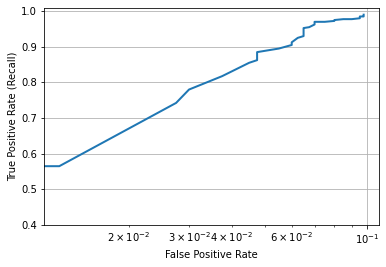

In [67]:
thresholds = np.arange(0,0.4,1e-2)
tprs, fprs = [], []

for threshold in thresholds:
    idx_true = np.where(labels==1)
    idx_false = np.where(labels==0)
    lensed = np.where(np.squeeze(d_test_pred)<=threshold)
    unlensed= np.where(np.squeeze(d_test_pred)>threshold)
    y_pred = 2.*np.ones_like(labels)
    y_pred[lensed] = 1
    y_pred[unlensed] = 0
    tpr = recall_score(labels,y_pred)
    C = confusion_matrix(labels,y_pred)
    fpr = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)
plt.plot(fprs,tprs,linewidth=2,label='ROC curve')
plt.ylim(0.4,1.01)
#plt.plot([0,1],[0,1],'k--')
plt.xscale('log')

plt.grid('both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [58]:
model.save('siamese_13082022_v1.h5')

# Test with Haris et al.

In [64]:
def contrastive_loss(y, preds, margin=0.3):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [70]:
model_name='siamese_13082022_v1'
model = load_model(model_name+'.h5',custom_objects={'contrastive_loss':contrastive_loss})


In [71]:
data_dir_ml1p0_test = '/home/srashti.goyal/lensid_runs/ML_1p0_AnalyticalPsd/data/qts/test/'

test_df= '/home/srashti.goyal/lensid_runs/ML1p0_kaggle_results/dataframes/ML_combined_kaggle.csv'

In [57]:
df_test= pd.read_csv(test_df)#pd.read_csv('/kaggle/input/haris-et-al-with-all-features/Predictions_saved models haris et al 1.csv')
df_test.tail()

,Unnamed: 0,img_0,img_1,Lensing,bayestar_skymaps_blu,bayestar_skymaps_d2,bayestar_skymaps_d3,bayestar_skymaps_lsq,"m1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn","m1, m2, ra, sin_dec, costheta_jn",...,densnet_xgbsky_bayestar_mul_3,densnet_xgbsky_bayestar_mul_4,densnet_xgbsky_bayestar_mul_5,densnet_xgbsky_bayestar_mul_6,densnet_xgbsky_bayestar_mul_7,densnet_xgbsky_bayestar_mul_8,densnet_xgbsky_bayestar_mul_9,densnet_xgbsky_bayestar_mul_10,densnet_xgbsky_bayestar_mul_0_fpp,"m1, m2, ra, sin_dec_fpp"
499787,499787,554245000.000000000-108490,595997000.000000000-191994,0,1.365422e-22,1.100924e-24,7.416256e-23,0.152882,1.703364e+00,1.306218e+00,...,5.617953e-11,5.323830e-11,3.781744e-11,5.754009e-11,4.617744e-11,5.093563e-11,5.437944e-11,4.355582e-11,0.820126,0.400813
499788,499788,653141000.000000000-306282,689564500.000000000-379129,0,1.604834e-11,1.293959e-13,1.824653e-11,0.142847,1.854477e-30,4.144270e-32,...,1.277932e-09,9.165771e-10,9.600741e-10,9.657164e-10,7.525222e-10,1.439519e-09,9.161058e-10,8.575772e-10,0.377858,0.900715
499789,499789,675816500.000000000-351633,588559000.000000000-177118,0,1.589665e+00,1.281728e-02,3.718310e-01,0.217838,6.472753e-06,6.622443e-06,...,2.947281e-10,3.003368e-10,2.703528e-10,3.278459e-10,2.761449e-10,3.409250e-10,3.003700e-10,2.169142e-10,0.468067,0.900711
499790,499790,599525500.000000000-199051,659585500.000000000-319171,0,7.492058e-01,6.040759e-03,1.743057e-02,0.094712,0.000000e+00,0.000000e+00,...,1.947911e-09,1.707155e-09,1.472434e-09,1.851704e-09,2.032786e-09,1.479124e-09,1.666960e-09,1.728036e-09,0.293131,1.000000
499791,499791,696527500.000000000-393055,597883000.000000000-195766,0,3.806309e-04,3.068983e-06,7.472681e-05,0.132500,4.854948e-03,9.256321e-03,...,1.270262e-08,1.760677e-08,1.613030e-08,1.972285e-08,1.262126e-08,2.006033e-08,1.477558e-08,1.330652e-08,0.156259,0.842162


In [83]:
df_test['siamese_sepcnn_'+det] =''

In [96]:
dl=1400
l= len(df_test.Lensing.values)

for i in range(0,l,dl):
    if i + dl <= l :
        print(i)
        x_0,x_1, labels,missing_ids=ml.generate_resize_siamese_fm(df_test[i:i+dl]).Siamese_input_matrix(
        det,
        data_mode_dense="current",
        data_dir=data_dir_ml1p0_test)
        df_test.loc[i:i+dl-1,'siamese_sepcnn_'+det]=model.predict([x_0, x_1])
    else:
        x_0,x_1, labels,missing_ids=ml.generate_resize_siamese_fm(df_test[i:l]).Siamese_input_matrix(
        det,
        data_mode_dense="current",
        data_dir=data_dir_ml1p0_test)
        df_test.loc[i:l-1,'siamese_sepcnn_'+det]=model.predict([x_0, x_1])


0


In [72]:
df_test.to_csv(model_name+'_predictions_haris_etal.csv')

In [ ]:
fig,rocs=FAR,efficiency,thrs,false_positive_rate, true_positive_rate, thresholds=ml.plot_ROCs(df_test,cols=['xgb_pred_pe_skymaps','combined_pred_pe_skymaps','xgb_pred_bayestar_skymaps','combined_pred_bayestar_skymaps','BLU_ra_dec','xgb_dense_QTS','siamese_sepcnn_'+det])
fig.savefig(model_name+'_ROCs_haris_etal.csv')


# load haris-et al results

In [101]:
model_name='siamese_13082022_v1'


df_test=pd.read_csv(model_name+'_predictions_haris_etal.csv')

In [102]:
df_test.tail()

,Unnamed: 0,Unnamed: 0.1,img_0,img_1,Lensing,bayestar_skymaps_blu,bayestar_skymaps_d2,bayestar_skymaps_d3,bayestar_skymaps_lsq,"m1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn",...,densnet_xgbsky_bayestar_mul_4,densnet_xgbsky_bayestar_mul_5,densnet_xgbsky_bayestar_mul_6,densnet_xgbsky_bayestar_mul_7,densnet_xgbsky_bayestar_mul_8,densnet_xgbsky_bayestar_mul_9,densnet_xgbsky_bayestar_mul_10,densnet_xgbsky_bayestar_mul_0_fpp,"m1, m2, ra, sin_dec_fpp",siamese_sepcnn_H1
499787,499787,499787,554245000.000000000-108490,595997000.000000000-191994,0,1.365422e-22,1.100924e-24,7.416256e-23,0.152882,1.703364e+00,...,5.323830e-11,3.781744e-11,5.754009e-11,4.617744e-11,5.093563e-11,5.437944e-11,4.355582e-11,0.820126,0.400813,0.126391
499788,499788,499788,653141000.000000000-306282,689564500.000000000-379129,0,1.604834e-11,1.293959e-13,1.824653e-11,0.142847,1.854477e-30,...,9.165771e-10,9.600741e-10,9.657164e-10,7.525222e-10,1.439519e-09,9.161058e-10,8.575772e-10,0.377858,0.900715,0.001360
499789,499789,499789,675816500.000000000-351633,588559000.000000000-177118,0,1.589665e+00,1.281728e-02,3.718310e-01,0.217838,6.472753e-06,...,3.003368e-10,2.703528e-10,3.278459e-10,2.761449e-10,3.409250e-10,3.003700e-10,2.169142e-10,0.468067,0.900711,0.017226
499790,499790,499790,599525500.000000000-199051,659585500.000000000-319171,0,7.492058e-01,6.040759e-03,1.743057e-02,0.094712,0.000000e+00,...,1.707155e-09,1.472434e-09,1.851704e-09,2.032786e-09,1.479124e-09,1.666960e-09,1.728036e-09,0.293131,1.000000,0.083681
499791,499791,499791,696527500.000000000-393055,597883000.000000000-195766,0,3.806309e-04,3.068983e-06,7.472681e-05,0.132500,4.854948e-03,...,1.760677e-08,1.613030e-08,1.972285e-08,1.262126e-08,2.006033e-08,1.477558e-08,1.330652e-08,0.156259,0.842162,0.006111


In [104]:
df_test.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'img_0', 'img_1', 'Lensing',
       'bayestar_skymaps_blu', 'bayestar_skymaps_d2', 'bayestar_skymaps_d3',
       'bayestar_skymaps_lsq',
       'm1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn',
       'm1, m2, ra, sin_dec, costheta_jn', 'ra, sin_dec',
       '# m1, m2, ra, sin_dec, a1, a2, costilt1, costilt2',
       'm1, m2, ra, sin_dec', 'm1, m2', 'xgb_pred_bayestar_skymaps',
       'xgb_pred_bayestar_skymaps_1', 'xgb_pred_bayestar_skymaps_2',
       'xgb_pred_bayestar_skymaps_3', 'xgb_pred_bayestar_skymaps_4',
       'xgb_pred_bayestar_skymaps_5', 'xgb_pred_bayestar_skymaps_6',
       'xgb_pred_bayestar_skymaps_7', 'xgb_pred_bayestar_skymaps_8',
       'xgb_pred_bayestar_skymaps_9', 'xgb_pred_bayestar_skymaps_10',
       'xgb_pred_bayestar_skymaps_fpp', 'ra, sin_dec_fpp', 'dense_H1_0',
       'mean_overlap_qts_H1', 'std_overlap_qts_H1', 'lsq_overlap_qts_H1',
       'dense_L1_0', 'mean_overlap_qts_L1', 'std_overlap_qts_L1',
       'l

In [113]:
df_test['inv_siamese_sepcnn_'+det] = 1/df_test['siamese_sepcnn_'+det]

BLU masses+sky auc = 0.9916
ML sky auc = 0.9708
BLU masses auc = 0.9164
BLU sky auc = 0.9777
ML QTs auc = 0.9085
DenseNet H1 auc = 0.8790
Siamese_specCNN auc = 0.7396


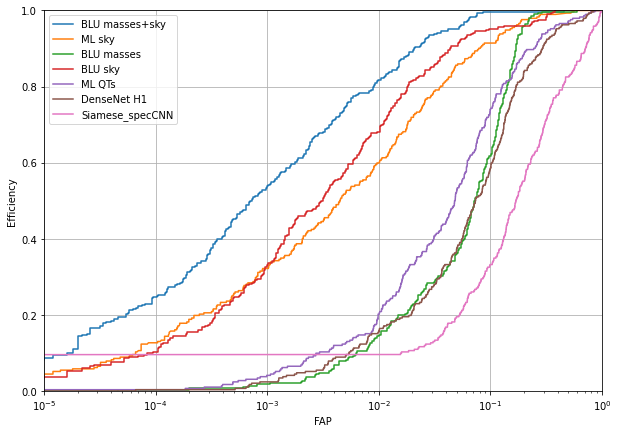

In [115]:
columns = ['m1, m2, ra, sin_dec, costheta_jn','xgb_pred_bayestar_skymaps','m1, m2','ra, sin_dec','xgb_dense_QTS_0','dense_H1_0','inv_siamese_sepcnn_'+det]
labels=['BLU masses+sky','ML sky','BLU masses','BLU sky','ML QTs','DenseNet H1','Siamese_specCNN']
fig,rocs=ml.plot_ROCs(df_test,cols=columns,labels=labels)

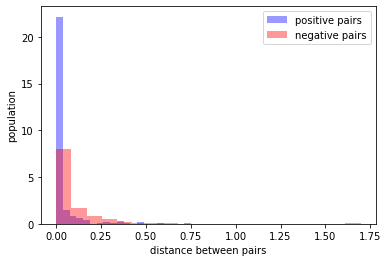

In [130]:
labels=df_test.Lensing.values
d_test_pred=df_test['siamese_sepcnn_'+det].values
idx_test_true = np.where(labels==1)
idx_test_false = np.where(labels==0)

plt.hist(d_test_pred[idx_test_true],20,color='b',alpha=0.4,label = 'positive pairs',density=True)
plt.hist(d_test_pred[idx_test_false],20,color='r',alpha=0.4, label= 'negative pairs',density=True)
plt.xlabel('distance between pairs')
plt.ylabel('population')
plt.legend(loc='best')
plt.show()

In [131]:
threshold = thresholds[t_idx]


lensed = np.where(np.squeeze(d_test_pred)<=threshold)
unlensed = np.where(np.squeeze(d_test_pred)>threshold)

y_pred = 2.*np.ones_like(labels)
y_pred[lensed] = 1
y_pred[unlensed] = 0

confusion_matrix(labels,y_pred), accuracy_score(labels,y_pred)

(array([[ 45681, 453819],
        [    10,    282]]),
 0.09196425713096648)

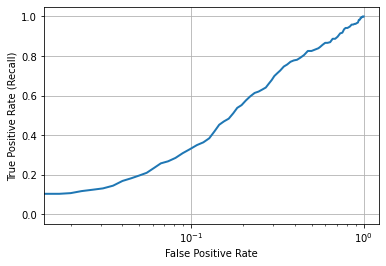

In [146]:
thresholds = np.logspace(-4,0.4,100)#np.arange(0,2,5e-2)
tprs, fprs = [], []

for threshold in thresholds:
    lensed = np.where(np.squeeze(d_test_pred)<=threshold)
    unlensed= np.where(np.squeeze(d_test_pred)>threshold)
    y_pred = 2.*np.ones_like(labels)
    y_pred[lensed] = 1
    y_pred[unlensed] = 0
    tpr = recall_score(labels,y_pred)
    C = confusion_matrix(labels,y_pred)
    fpr = C[0,1]/(C[0,0]+C[0,1])
    tprs.append(tpr)
    fprs.append(fpr)
plt.plot(fprs,tprs,linewidth=2,label='ROC curve')
#plt.ylim(0.4,1.01)
#plt.plot([0,1],[0,1],'k--')
plt.xscale('log')

plt.grid('both')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [143]:
d_test_pred.min(),d_test_pred.max()

(0.0003162277571391, 1.6957180500030518)

In [147]:
#np.logspace(-4,0.4,100)